In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression, SelectKBest, chi2
import statsmodels.api as sm
import numpy as np

In [90]:
data = pd.read_csv (r'data_covidcare_ruralurban.csv')

## Data sources:
USDA Rural-Urban Continuum Codes    
https://www.ers.usda.gov/data-products/rural-urban-continuum-codes.aspx   
US census income and poverty data   
https://www.census.gov/data/tables/2019/demo/income-poverty/p60-266.html   
Covid-19 health system capacity   
https://github.com/covidcaremap/covid19-healthsystemcapacity/tree/master/data       
NY times covid-19 cases/deaths count   
https://github.com/nytimes/covid-19-data   

## Exploratory Analysis

In [91]:
def unique(list1): 
  
    # intilize a null list 
    unique_list = [] 
      
    # traverse for all elements 
    for x in list1: 
        # check if exists in unique_list or not 
        if x not in unique_list: 
            unique_list.append(x) 
    # print list 
    for x in unique_list: 
        print (x)

Top 25 counties with most cases and deaths distributed in the following states: 

In [92]:
data.columns

Index(['fips_code', 'county_x', 'staffed_all_beds', 'staffed_icu_beds',
       'licensed_all_beds', 'all_bed_occupancy_rate', 'icu_bed_occupancy_rate',
       'population', 'population_20', 'population_65',
       'staffed_all_beds_.per_1000_people.',
       'staffed_all_beds_.per_1000_adults_20..',
       'staffed_all_beds_.per_1000_elderly_65..',
       'staffed_icu_beds_.per_1000_people.',
       'staffed_icu_beds_.per_1000_adults_20..',
       'staffed_icu_beds_.per_1000_elderly_65..',
       'licensed_all_beds_per_1000_people',
       'licensed_all_beds_.per_1000_adults_20..',
       'licensed_all_beds_.per_1000_elderly_65..', 'state', 'cases', 'deaths',
       'State.x', 'County_Name', 'Population_2010', 'RUCC_2013', 'Description',
       'State.y', 'Area_name', 'Rural.urban_Continuum_Code_2013',
       'Urban_Influence_Code_2013', 'peopleinpoverty2018',
       'medianhouseholdincome'],
      dtype='object')

In [93]:
data1 = data[['cases', 'deaths', 'state', 'county_x']]
top = data1.sort_values(['cases', 'deaths'], ascending=False).head(25)
unique(list(top['state']))

New York
Illinois
California
Michigan
New Jersey
Pennsylvania
Florida
Massachusetts
Connecticut
Louisiana
Washington


Top states with most cases and deaths across all counties:

In [94]:
data1.groupby(['state']).sum().sort_values(['cases', 'deaths'], ascending=False).head(11)

,cases,deaths
state,,
New York,114584.0,4685.0
New Jersey,94820.0,5061.0
Massachusetts,42090.0,2173.0
California,37572.0,1425.0
Pennsylvania,36310.0,1706.0
Illinois,34563.0,1560.0
Michigan,33138.0,2785.0
Florida,28239.0,889.0
Louisiana,24188.0,1386.0


Text(0,0.5,'deathes')

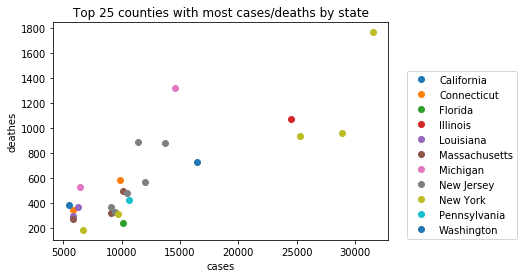

In [96]:
groups = top.groupby("state")
for name, group in groups:
    plt.plot(group["cases"], group["deaths"], marker="o", linestyle="", label=name)
plt.legend(loc='best', bbox_to_anchor=(0.9, 0., 0.5, 0.8))
plt.title('Top 25 counties with most cases/deaths by state')
plt.xlabel('cases')
plt.ylabel('deathes')

## Methods
1. Model capability using multiple linear regression.  
2. Apply multivariate bootstrap techniques with hypothesis testing for model selection.  
3. Clustering (hierarchical clustering) for capability classification based on US regions. 

## 1. Regression
Multiple linear regression was conducted on the following variables: population_65+, population, licensed_all_beds, staffed_all_beds, population_20+, and licensed_all_beds_per_1000_people. Variables were selected after running forward selection and backward eliminiation. 